In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgbm
from lightgbm import log_evaluation, record_evaluation, early_stopping
import xgboost as xgb
import optuna
import mlflow
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [211]:
np.random.seed(26)

In [212]:
df_init = pd.read_parquet('kaggleton_4_shuffled_data.parquet')
df_init

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,price,car_age
968,Lexus,GX,Gas,51271,2001,First,2,Transparent,Automatic,361263.41,22
848,Porsche,Macan,Hybrid,20254,2018,First,4,Black,Automatic,683604.60,5
974,Lexus,GX,Hybrid,55448,2009,First,0,Golden,Manual,683398.37,14
91,Audi,A6,Diesel,197300,2011,Third,2,Aquamarine,Automatic,11612.14,12
808,Volvo,XC40,Hybrid,15916,2022,First,3,Silver,Automatic,872879.46,1
...,...,...,...,...,...,...,...,...,...,...,...
772,Volvo,XC60,Hybrid,61570,2000,Third,0,Aquamarine,Automatic,203756.50,23
501,Volkswagen,Jetta,Electric,171319,2015,First,0,White,Manual,236128.14,8
165,Ford,Mustang,Hybrid,100259,2013,First,0,Blue,Automatic,1013045.09,10
680,Jeep,Compass,Gas,49482,2010,Second,4,Red,Automatic,89296.37,13


# Deleting data where y == 0 (according to the task)

In [213]:
df = df_init[df_init['price'] != 0].copy()
df

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,price,car_age
968,Lexus,GX,Gas,51271,2001,First,2,Transparent,Automatic,361263.41,22
848,Porsche,Macan,Hybrid,20254,2018,First,4,Black,Automatic,683604.60,5
974,Lexus,GX,Hybrid,55448,2009,First,0,Golden,Manual,683398.37,14
91,Audi,A6,Diesel,197300,2011,Third,2,Aquamarine,Automatic,11612.14,12
808,Volvo,XC40,Hybrid,15916,2022,First,3,Silver,Automatic,872879.46,1
...,...,...,...,...,...,...,...,...,...,...,...
772,Volvo,XC60,Hybrid,61570,2000,Third,0,Aquamarine,Automatic,203756.50,23
501,Volkswagen,Jetta,Electric,171319,2015,First,0,White,Manual,236128.14,8
165,Ford,Mustang,Hybrid,100259,2013,First,0,Blue,Automatic,1013045.09,10
680,Jeep,Compass,Gas,49482,2010,Second,4,Red,Automatic,89296.37,13


# 1. Data understanding (EDA)

# Some graphs to understand the contents of the data

1. Categorical features

In [214]:
unique_brands = df['brand'].nunique()
unique_models = df['model'].nunique()
unique_fuels = df['fuel_type'].nunique()
unique_owners = df['owner_type'].nunique()
unique_colors = df['color'].nunique()
unique_transmission = df['transmission'].nunique()

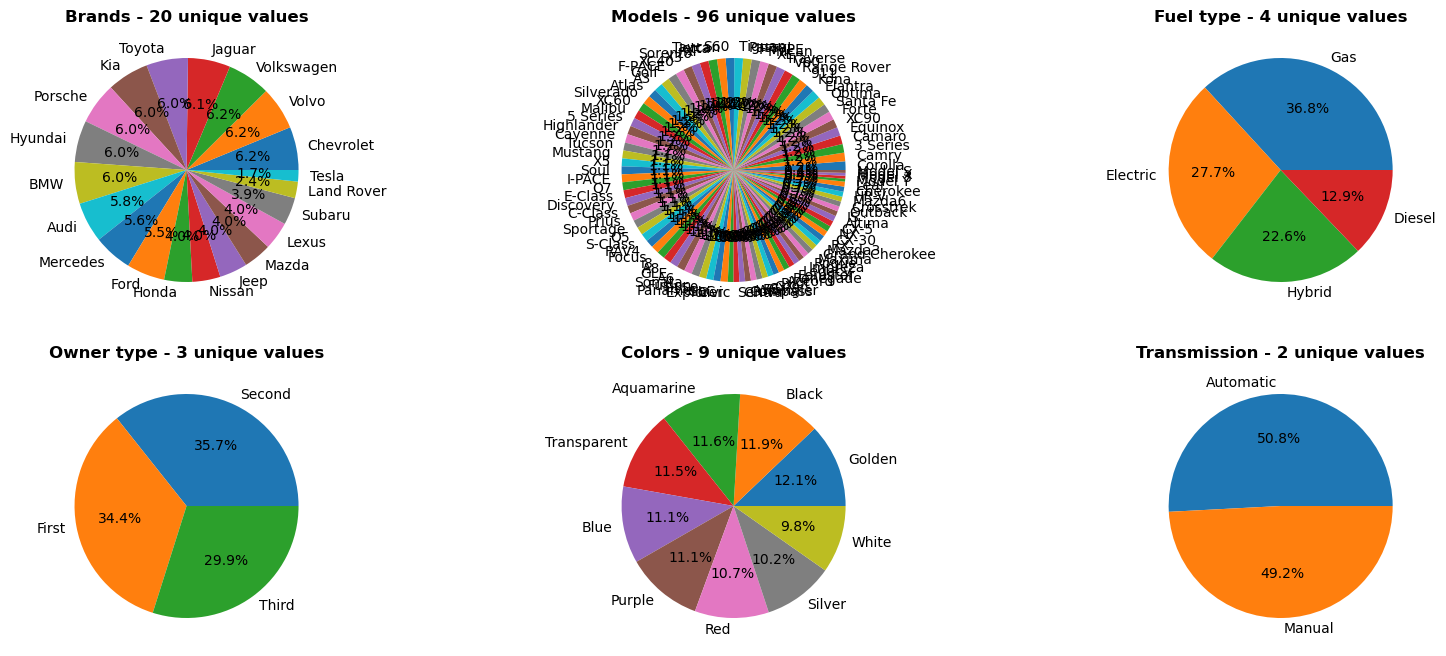

In [215]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize = (20,8))

df['brand'].value_counts().plot(kind='pie', autopct = '%1.1f%%', ax=axis[0,0])
axis[0,0].set_title(f"Brands - {unique_brands} unique values", fontweight = 'bold', color='black')
axis[0,0].set_ylabel('')

df['model'].value_counts().plot(kind='pie', autopct = '%1.1f%%', ax=axis[0,1])
axis[0,1].set_title(f"Models - {unique_models} unique values", fontweight = 'bold', color='black')
axis[0,1].set_ylabel('')

df['fuel_type'].value_counts().plot(kind='pie', autopct = '%1.1f%%', ax=axis[0,2])
axis[0,2].set_title(f"Fuel type - {unique_fuels} unique values", fontweight = 'bold', color='black')
axis[0,2].set_ylabel('')

df['owner_type'].value_counts().plot(kind='pie', autopct = '%1.1f%%', ax=axis[1,0])
axis[1,0].set_title(f"Owner type - {unique_owners} unique values", fontweight = 'bold', color='black')
axis[1,0].set_ylabel('')

df['color'].value_counts().plot(kind='pie', autopct = '%1.1f%%', ax=axis[1,1])
axis[1,1].set_title(f"Colors - {unique_colors} unique values", fontweight = 'bold', color='black')
axis[1,1].set_ylabel('')

df['transmission'].value_counts().plot(kind='pie', autopct = '%1.1f%%', ax=axis[1,2])
axis[1,2].set_title(f"Transmission - {unique_transmission} unique values", fontweight = 'bold', color='black')
axis[1,2].set_ylabel('')

plt.show()

2. Numerical features

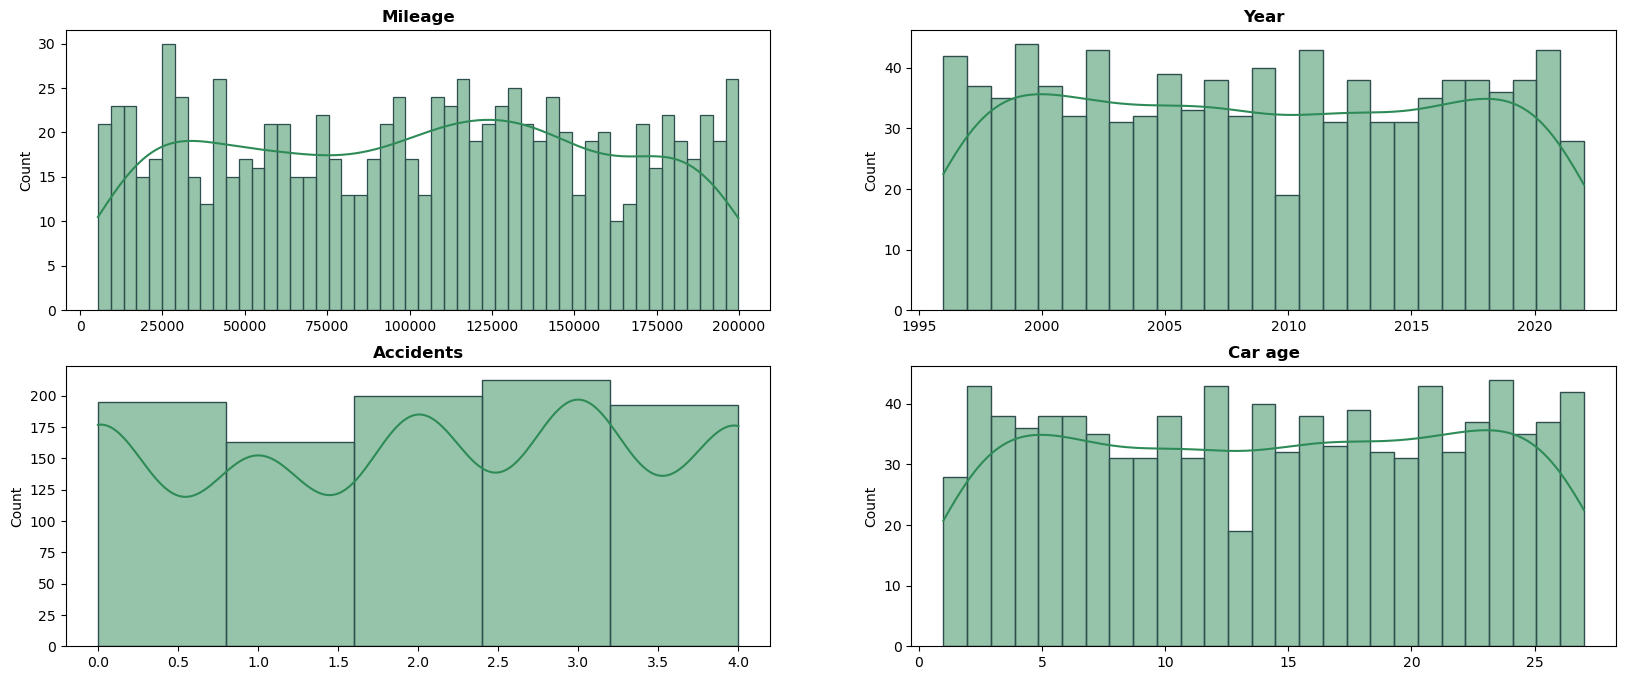

In [216]:
_, axis = plt.subplots(ncols=2, nrows=2, figsize=(20,8))

sns.histplot(df['mileage'], bins=50, color='seagreen', edgecolor='darkslategray', kde=True, ax=axis[0,0])
axis[0,0].set_title("Mileage", fontweight = 'bold', color='black')
axis[0,0].set_xlabel('')

sns.histplot(df['year'], bins=27, color='seagreen', edgecolor='darkslategray', kde=True, ax=axis[0,1])
axis[0,1].set_title("Year", fontweight = 'bold', color='black')
axis[0,1].set_xlabel('')

sns.histplot(df['accidents'], bins=5, color='seagreen', edgecolor='darkslategray', kde=True, ax=axis[1,0])
axis[1,0].set_title("Accidents", fontweight = 'bold', color='black')
axis[1,0].set_xlabel('')

sns.histplot(df['car_age'], bins=27, color='seagreen', edgecolor='darkslategray', kde=True, ax=axis[1,1])
axis[1,1].set_title("Car age", fontweight = 'bold', color='black')
axis[1,1].set_xlabel('')

plt.show()

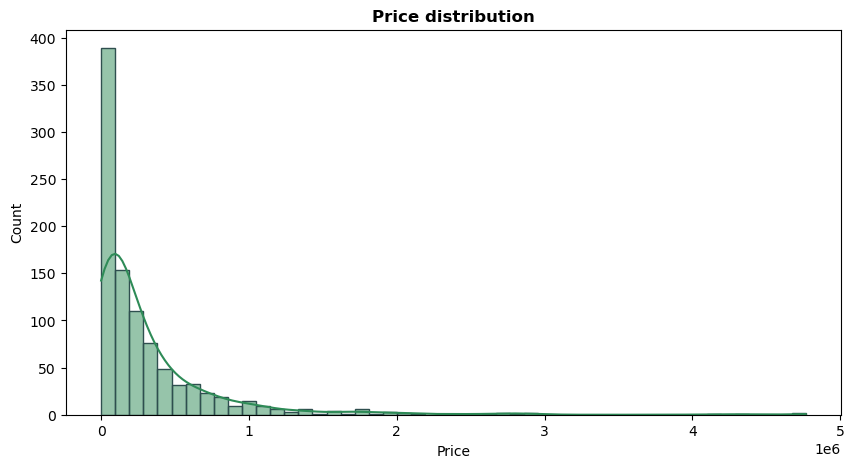

In [217]:
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, color='seagreen', edgecolor='darkslategray', kde=True)
plt.title('Price distribution', fontweight = 'bold', color='black')
plt.xlabel('Price')
plt.ticklabel_format(useOffset=False)
plt.show()

# Some correlation between features and price

1. Categorical features

In [218]:
max_price_bmw = df.groupby(['brand'])['price'].mean()['BMW']
max_price_bmw

607819.9356896552

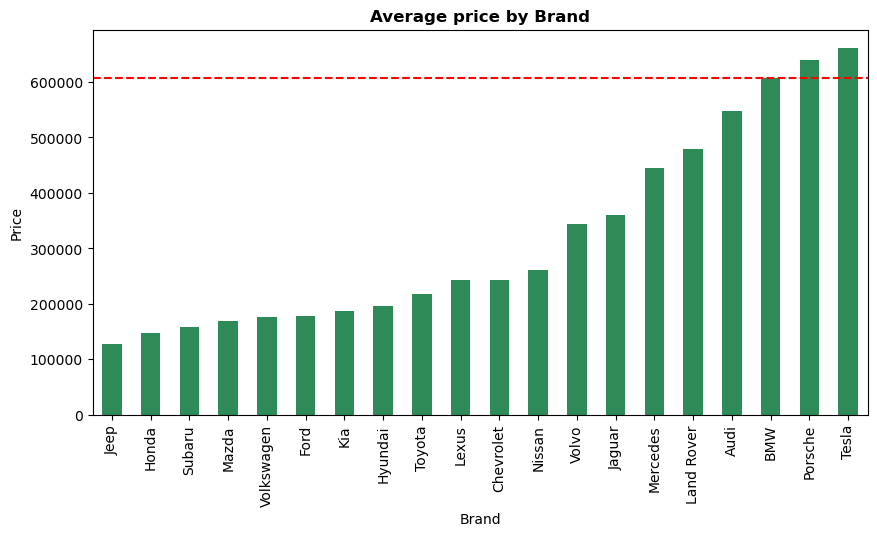

In [219]:
plt.figure(figsize=(10,5))
df.groupby(['brand'])['price'].mean().sort_values().plot(kind='bar', color='seagreen')
plt.title("Average price by Brand", fontweight = 'bold', color='black')
plt.xlabel("Brand")
plt.ylabel("Price")
plt.axhline(max_price_bmw, linestyle='--', c='red')

plt.show()

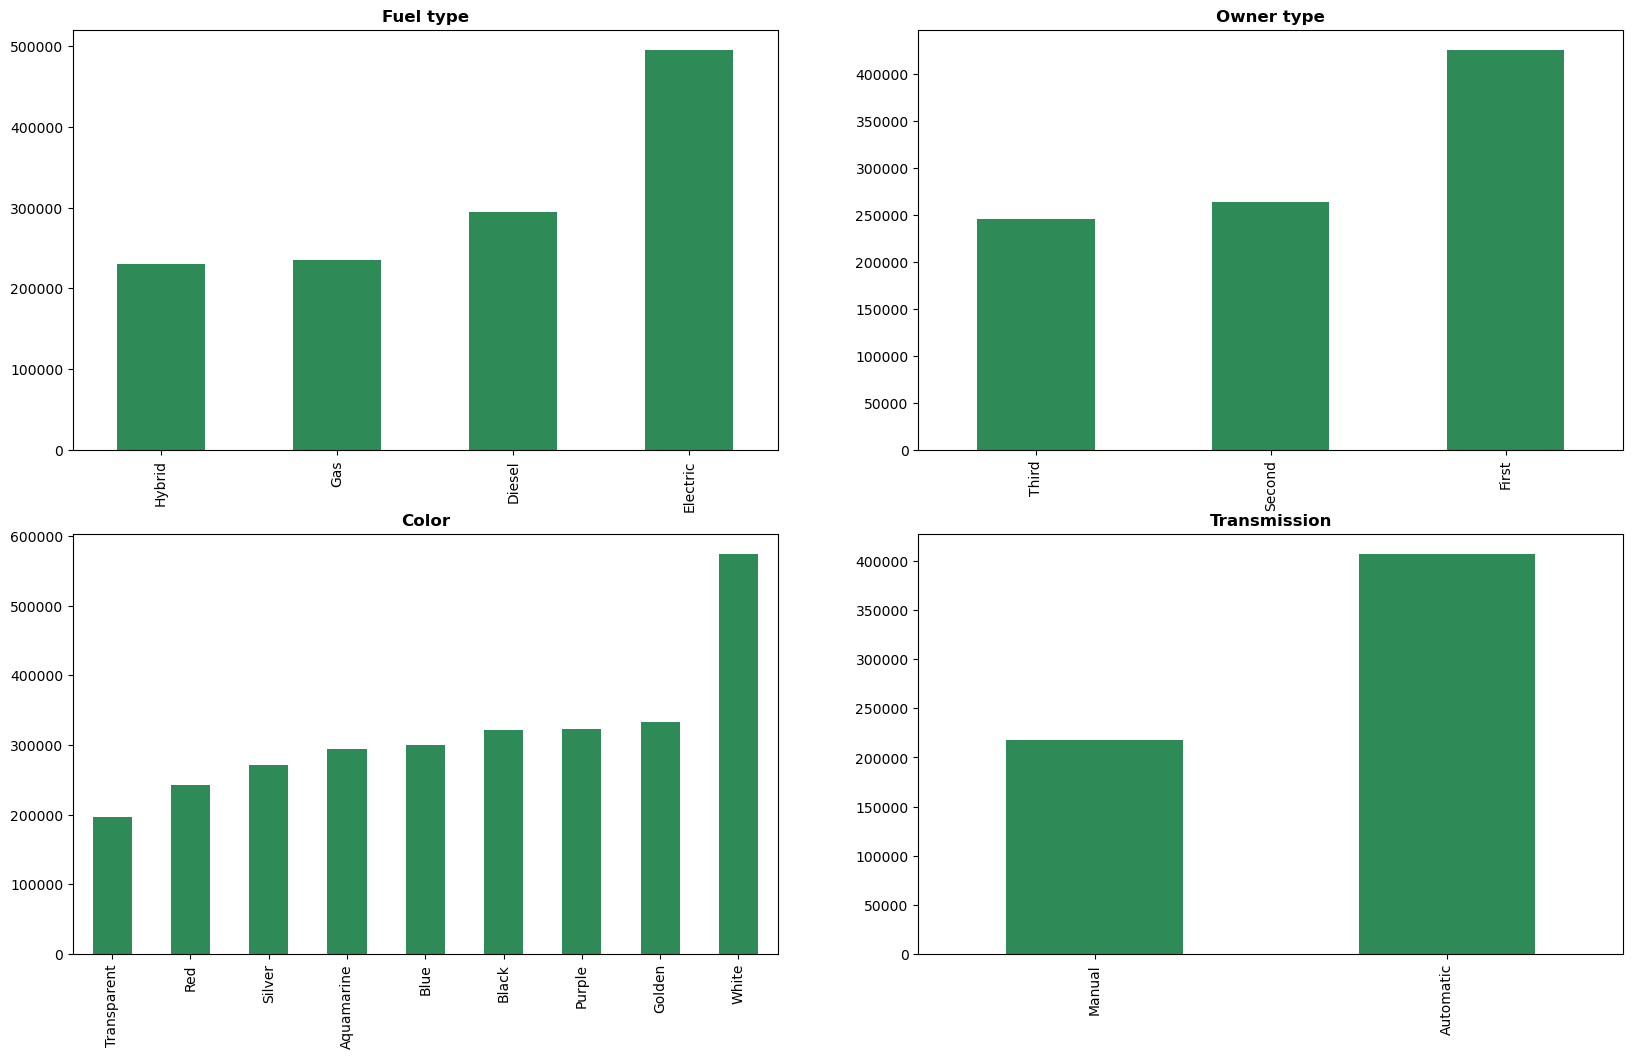

In [220]:
_, axis = plt.subplots(ncols=2, nrows=2, figsize=(20,12))

df.groupby(['fuel_type'])['price'].mean().sort_values().plot(kind='bar', color='seagreen', ax=axis[0,0])
axis[0,0].set_title("Fuel type", fontweight = 'bold', color='black')
axis[0,0].set_xlabel('')

df.groupby(['owner_type'])['price'].mean().sort_values().plot(kind='bar', color='seagreen', ax=axis[0,1])
axis[0,1].set_title("Owner type", fontweight = 'bold', color='black')
axis[0,1].set_xlabel('')

df.groupby(['color'])['price'].mean().sort_values().plot(kind='bar', color='seagreen', ax=axis[1,0])
axis[1,0].set_title("Color", fontweight = 'bold', color='black')
axis[1,0].set_xlabel('')

df.groupby(['transmission'])['price'].mean().sort_values().plot(kind='bar', color='seagreen', ax=axis[1,1])
axis[1,1].set_title("Transmission", fontweight = 'bold', color='black')
axis[1,1].set_xlabel('')

plt.show()

Some combinations of categorical features

In [221]:
max_price_transmis_fuel = df.groupby(['transmission', 'fuel_type'])['price'].mean()['Manual']['Electric']
max_price_transmis_fuel

350904.38801526715

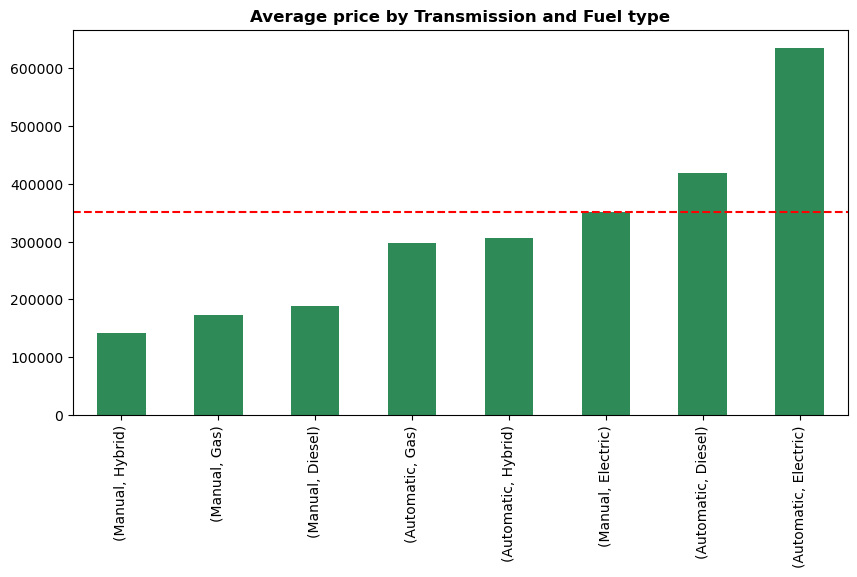

In [222]:
plt.figure(figsize=(10,5))
df.groupby(['transmission', 'fuel_type'])['price'].mean().sort_values().plot(kind='bar', color='seagreen')
plt.title("Average price by Transmission and Fuel type", c='black', fontweight='bold')
plt.axhline(max_price_transmis_fuel, linestyle='--', c='red')
plt.xlabel('')

plt.show()

2. Numerical features

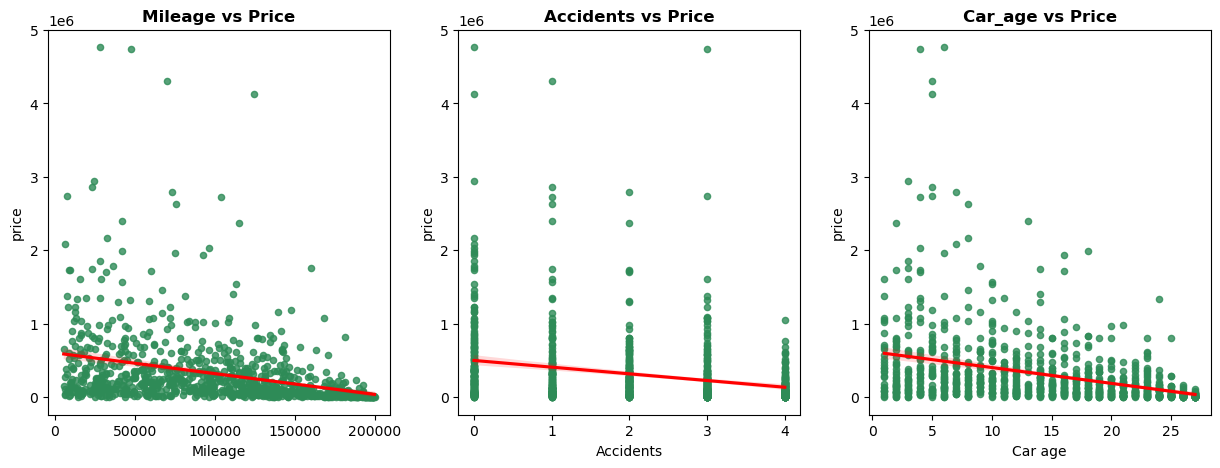

In [223]:
_, axis = plt.subplots(ncols=3, figsize=(15,5))

sns.regplot(x='mileage', y='price', data=df, scatter_kws={'s': 20, 'color': 'seagreen'}, line_kws={'color': 'red'}, ax=axis[0])
axis[0].set_title("Mileage vs Price", color='black', fontweight='bold')
axis[0].set_xlabel('Mileage')

sns.regplot(x='accidents', y='price', data=df, scatter_kws={'s': 20, 'color': 'seagreen'}, line_kws={'color': 'red'}, ax=axis[1])
axis[1].set_title("Accidents vs Price", color='black', fontweight='bold')
axis[1].set_xlabel('Accidents')

sns.regplot(x='car_age', y='price', data=df, scatter_kws={'s': 20, 'color': 'seagreen'}, line_kws={'color': 'red'}, ax=axis[2])
axis[2].set_title("Car_age vs Price", color='black', fontweight='bold')
axis[2].set_xlabel('Car age')

plt.show()

# 2. Data preparation

# Adding more features

Mileage_per_year, Accidents_per_year

In [224]:
df['mileage_per_year'] = df['mileage'] / df['car_age']
df['accidents_per_year'] = df['accidents'] / df['car_age']

Transmission_fuel

In [225]:
df['transmission_fuel'] = df['transmission'] + '_' + df['fuel_type']

Year_range based on percentiles

In [226]:
print(df['year'].describe(percentiles=[.25, .5, .75]))

count     964.000000
mean     2008.819502
std         7.927409
min      1996.000000
25%      2002.000000
50%      2009.000000
75%      2016.000000
max      2022.000000
Name: year, dtype: float64


In [227]:
#270, 245, 228, 221
df[df['year'] <= 2002]
df[(df['year'] > 2002) & (df['year'] <= 2009)]
df[(df['year'] > 2009) & (df['year'] <= 2016)]
df[df['year'] > 2016]

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,price,car_age,mileage_per_year,accidents_per_year,transmission_fuel
848,Porsche,Macan,Hybrid,20254,2018,First,4,Black,Automatic,683604.60,5,4050.800000,0.800000,Automatic_Hybrid
808,Volvo,XC40,Hybrid,15916,2022,First,3,Silver,Automatic,872879.46,1,15916.000000,3.000000,Automatic_Hybrid
777,Volvo,XC60,Electric,105497,2017,Third,2,Aquamarine,Automatic,689991.22,6,17582.833333,0.333333,Automatic_Electric
493,Volkswagen,Jetta,Gas,190412,2019,First,0,Silver,Manual,31543.40,4,47603.000000,0.000000,Manual_Gas
314,Nissan,Leaf,Gas,55108,2018,Second,0,Red,Automatic,860563.13,5,11021.600000,0.000000,Automatic_Gas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,Nissan,Maxima,Electric,24830,2022,Second,3,Black,Manual,660747.93,1,24830.000000,3.000000,Manual_Electric
619,Chevrolet,Equinox,Electric,168379,2021,Second,0,Purple,Manual,157731.72,2,84189.500000,0.000000,Manual_Electric
458,Volkswagen,Golf,Gas,30945,2017,Third,4,Purple,Automatic,133999.15,6,5157.500000,0.666667,Automatic_Gas
382,Mercedes,GLC,Electric,170656,2017,Third,0,White,Automatic,576346.34,6,28442.666667,0.000000,Automatic_Electric


In [228]:
df['year_range'] = pd.cut(df['year'],
                          bins=[1995, 2002, 2009, 2016, float('inf')],
                          labels=['1996-2002', '2003-2009', '2010-2016', '2017-2022'])

Mileage_category based on percentiles

In [229]:
print(df['mileage'].describe(percentiles=[.25, .5, .75]))

count       964.000000
mean     102498.398340
std       56777.604238
min        5404.000000
25%       53395.000000
50%      105917.500000
75%      147803.500000
max      199806.000000
Name: mileage, dtype: float64


In [230]:
# 241 lines everywhere
df[df['mileage'] <= 53395.0]
df[(df['mileage'] > 53395.0) & (df['mileage'] <= 105917.5)]
df[(df['mileage'] > 105917.5) & (df['mileage'] <= 147803.5)]
df[df['mileage'] > 147803.5]

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,price,car_age,mileage_per_year,accidents_per_year,transmission_fuel,year_range
91,Audi,A6,Diesel,197300,2011,Third,2,Aquamarine,Automatic,11612.14,12,16441.666667,0.166667,Automatic_Diesel,2010-2016
493,Volkswagen,Jetta,Gas,190412,2019,First,0,Silver,Manual,31543.40,4,47603.000000,0.000000,Manual_Gas,2017-2022
340,Mercedes,C-Class,Diesel,155810,2021,First,3,Red,Manual,132637.50,2,77905.000000,1.500000,Manual_Diesel,2017-2022
330,Nissan,Maxima,Gas,176890,2016,Third,2,Transparent,Manual,37219.79,7,25270.000000,0.285714,Manual_Gas,2010-2016
721,Kia,Sportage,Gas,188808,2012,First,4,Golden,Automatic,12789.67,11,17164.363636,0.363636,Automatic_Gas,2010-2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Ford,Mustang,Gas,178629,2000,First,4,Black,Automatic,16050.11,23,7766.478261,0.173913,Automatic_Gas,1996-2002
217,Honda,Accord,Hybrid,182789,2014,Third,0,White,Manual,47648.16,9,20309.888889,0.000000,Manual_Hybrid,2010-2016
382,Mercedes,GLC,Electric,170656,2017,Third,0,White,Automatic,576346.34,6,28442.666667,0.000000,Automatic_Electric,2017-2022
501,Volkswagen,Jetta,Electric,171319,2015,First,0,White,Manual,236128.14,8,21414.875000,0.000000,Manual_Electric,2010-2016


In [231]:
df['mileage_category'] = pd.cut(df['mileage'],
                                bins=[0, 53395.0, 105917.5, 147803.5, float('inf')],
                                labels=['Low', 'Middle', 'High', 'Very high'])

In [232]:
df

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,price,car_age,mileage_per_year,accidents_per_year,transmission_fuel,year_range,mileage_category
968,Lexus,GX,Gas,51271,2001,First,2,Transparent,Automatic,361263.41,22,2330.500000,0.090909,Automatic_Gas,1996-2002,Low
848,Porsche,Macan,Hybrid,20254,2018,First,4,Black,Automatic,683604.60,5,4050.800000,0.800000,Automatic_Hybrid,2017-2022,Low
974,Lexus,GX,Hybrid,55448,2009,First,0,Golden,Manual,683398.37,14,3960.571429,0.000000,Manual_Hybrid,2003-2009,Middle
91,Audi,A6,Diesel,197300,2011,Third,2,Aquamarine,Automatic,11612.14,12,16441.666667,0.166667,Automatic_Diesel,2010-2016,Very high
808,Volvo,XC40,Hybrid,15916,2022,First,3,Silver,Automatic,872879.46,1,15916.000000,3.000000,Automatic_Hybrid,2017-2022,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Volvo,XC60,Hybrid,61570,2000,Third,0,Aquamarine,Automatic,203756.50,23,2676.956522,0.000000,Automatic_Hybrid,1996-2002,Middle
501,Volkswagen,Jetta,Electric,171319,2015,First,0,White,Manual,236128.14,8,21414.875000,0.000000,Manual_Electric,2010-2016,Very high
165,Ford,Mustang,Hybrid,100259,2013,First,0,Blue,Automatic,1013045.09,10,10025.900000,0.000000,Automatic_Hybrid,2010-2016,Middle
680,Jeep,Compass,Gas,49482,2010,Second,4,Red,Automatic,89296.37,13,3806.307692,0.307692,Automatic_Gas,2010-2016,Low


# Encoding categorical features

In [233]:
# grouping data by mean price by transmission and fuel_type in ascending order for encoding
df.groupby(['transmission', 'fuel_type'])['price'].mean().sort_values()

transmission  fuel_type
Manual        Hybrid       140847.845600
              Gas          172567.128466
              Diesel       189254.485373
Automatic     Gas          297868.041117
              Hybrid       305839.952119
Manual        Electric     350904.388015
Automatic     Diesel       419105.275088
              Electric     635033.583750
Name: price, dtype: float64

In [234]:
# grouping data by mean price by brands in ascending order for encoding
df.groupby(['brand'])['price'].mean().sort_values()

brand
Jeep          127520.879744
Honda         147093.510513
Subaru        158443.802105
Mazda         169168.497692
Volkswagen    175259.209000
Ford          178317.043585
Kia           186503.132069
Hyundai       196128.537069
Toyota        217336.943276
Lexus         242350.590000
Chevrolet     242550.890000
Nissan        260428.751538
Volvo         343553.786167
Jaguar        360780.634915
Mercedes      444763.413148
Land Rover    478792.303043
Audi          548200.083214
BMW           607819.935690
Porsche       638756.608966
Tesla         661401.871250
Name: price, dtype: float64

In [235]:
df.groupby(['year_range'])['price'].mean().sort_values()

C:\Users\ksush\AppData\Local\Temp\ipykernel_10112\4033365935.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['year_range'])['price'].mean().sort_values()


year_range
1996-2002    102052.459741
2003-2009    256535.302898
2010-2016    386328.466798
2017-2022    562343.812353
Name: price, dtype: float64

In [236]:
categorical_features = ['brand', 'model', 'fuel_type', 'owner_type', 'color', 'transmission', 'transmission_fuel', 'year_range', 'mileage_category']

In [237]:
encoders = {}

for feature in categorical_features:
    if feature == 'owner_type':
        ordinal_encoder = OrdinalEncoder(categories=([['Third', 'Second', 'First']]))
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['owner_type']]).astype(int)
        encoders[feature] = ordinal_encoder
    
    elif feature == 'brand':
        ordinal_encoder = OrdinalEncoder(categories=([['Jeep', 'Honda', 'Subaru', 'Mazda', 'Volkswagen', 'Ford', 'Kia', 'Hyundai', 'Toyota', 'Lexus',
                                                       'Chevrolet', 'Nissan', 'Volvo', 'Jaguar', 'Mercedes', 'Land Rover', 'Audi', 'BMW', 'Porsche', 'Tesla']]))
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['brand']]).astype(int)
        encoders[feature] = ordinal_encoder
    
    elif feature == 'transmission_fuel':
        ordinal_encoder = OrdinalEncoder(categories=([['Manual_Hybrid', 'Manual_Gas', 'Manual_Diesel', 'Automatic_Gas', 'Automatic_Hybrid',
                                                       'Manual_Electric', 'Automatic_Diesel', 'Automatic_Electric']]))
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['transmission_fuel']]).astype(int)
        encoders[feature] = ordinal_encoder

    elif feature == 'year_range':
        ordinal_encoder = OrdinalEncoder(categories=([['1996-2002', '2003-2009', '2010-2016', '2017-2022']]))
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['year_range']]).astype(int)
        encoders[feature] = ordinal_encoder
    
    elif feature == 'mileage_category':
        ordinal_encoder = OrdinalEncoder(categories=([['Very high', 'High', 'Middle', 'Low']]))
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['mileage_category']]).astype(int)
        encoders[feature] = ordinal_encoder

    else:
        label_encoder = LabelEncoder()
        df.loc[:, feature] = label_encoder.fit_transform(df[feature])
        encoders[feature] = label_encoder

In [238]:
encoders

{'brand': OrdinalEncoder(categories=[['Jeep', 'Honda', 'Subaru', 'Mazda', 'Volkswagen',
                             'Ford', 'Kia', 'Hyundai', 'Toyota', 'Lexus',
                             'Chevrolet', 'Nissan', 'Volvo', 'Jaguar',
                             'Mercedes', 'Land Rover', 'Audi', 'BMW', 'Porsche',
                             'Tesla']]),
 'model': LabelEncoder(),
 'fuel_type': LabelEncoder(),
 'owner_type': OrdinalEncoder(categories=[['Third', 'Second', 'First']]),
 'color': LabelEncoder(),
 'transmission': LabelEncoder(),
 'transmission_fuel': OrdinalEncoder(categories=[['Manual_Hybrid', 'Manual_Gas', 'Manual_Diesel',
                             'Automatic_Gas', 'Automatic_Hybrid',
                             'Manual_Electric', 'Automatic_Diesel',
                             'Automatic_Electric']]),
 'year_range': OrdinalEncoder(categories=[['1996-2002', '2003-2009', '2010-2016',
                             '2017-2022']]),
 'mileage_category': OrdinalEncoder(categor

In [239]:
df

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,price,car_age,mileage_per_year,accidents_per_year,transmission_fuel,year_range,mileage_category
968,9,37,2,51271,2001,2,2,7,0,361263.41,22,2330.500000,0.090909,3,0,3
848,18,49,3,20254,2018,2,4,1,0,683604.60,5,4050.800000,0.800000,4,3,3
974,9,37,3,55448,2009,2,0,3,1,683398.37,14,3960.571429,0.000000,0,1,2
91,16,4,0,197300,2011,0,2,0,0,11612.14,12,16441.666667,0.166667,6,2,0
808,12,90,3,15916,2022,2,3,6,0,872879.46,1,15916.000000,3.000000,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,12,91,3,61570,2000,0,0,0,0,203756.50,23,2676.956522,0.000000,4,0,2
501,4,45,1,171319,2015,2,0,8,1,236128.14,8,21414.875000,0.000000,5,2,0
165,5,58,3,100259,2013,2,0,2,0,1013045.09,10,10025.900000,0.000000,4,2,2
680,0,19,2,49482,2010,1,4,5,0,89296.37,13,3806.307692,0.307692,3,2,3


# Splitting data into train, val and test sets

In [240]:
train_val_size = int(len(df) * 0.8)

# splitting test set
test_df = df.iloc[train_val_size:]
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

# splitting train and val sets
train_val_df = df.iloc[:train_val_size]
train_val_X = train_val_df.drop('price', axis=1)
train_val_y = train_val_df['price']


X_train, X_val, y_train, y_val = train_test_split(train_val_X, train_val_y, test_size=0.2, random_state=26)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((616, 15), (155, 15), (193, 15), (616,), (155,), (193,))

# Scaling all features

In [241]:
scaler = MinMaxScaler(feature_range=(-1,1))

feature_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_val = pd.DataFrame(X_val, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [242]:
X_val

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,car_age,mileage_per_year,accidents_per_year,transmission_fuel,year_range,mileage_category
0,-0.578947,-0.052632,-0.333333,0.246034,0.923077,0.0,1.0,-0.25,-1.0,-0.923077,-0.322517,0.000000,1.000000,1.000000,-0.333333
1,0.894737,0.031579,-0.333333,-0.809281,0.846154,-1.0,-1.0,-0.25,-1.0,-0.846154,-0.915489,-1.000000,1.000000,1.000000,1.000000
2,-0.368421,0.263158,1.000000,-0.911331,-0.769231,-1.0,-1.0,1.00,1.0,0.769231,-0.995982,-1.000000,-1.000000,-1.000000,1.000000
3,-0.789474,0.284211,1.000000,-0.499674,0.846154,1.0,1.0,1.00,-1.0,-0.846154,-0.808013,-0.333333,0.142857,1.000000,0.333333
4,0.473684,0.536842,0.333333,0.836974,-0.538462,-1.0,0.0,-1.00,-1.0,0.538462,-0.908362,-0.952381,-0.142857,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,-0.578947,0.747368,-1.000000,0.165903,0.461538,0.0,-1.0,-1.00,-1.0,-0.461538,-0.842875,-1.000000,0.714286,0.333333,-0.333333
151,-0.263158,0.578947,0.333333,0.314761,-0.384615,-1.0,-1.0,-0.25,1.0,0.384615,-0.927084,-1.000000,-0.714286,-0.333333,-0.333333
152,0.578947,-0.536842,0.333333,-0.738174,-0.692308,1.0,-1.0,-0.25,-1.0,0.692308,-0.987861,-1.000000,-0.142857,-1.000000,1.000000
153,-0.368421,0.684211,1.000000,-0.864699,0.153846,-1.0,0.0,-0.50,1.0,-0.153846,-0.985497,-0.916667,-1.000000,0.333333,1.000000


# 3. Modeling

1. Linear regression

In [243]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred_linear_regressor = linear_regressor.predict(X_val)

mae_linear_regression = mean_absolute_error(y_val, y_pred_linear_regressor)
mape_linear_regression = mean_absolute_percentage_error(y_val, y_pred_linear_regressor)
print(f"MAE linear regression: {mae_linear_regression:.2f}")
print(f"MAPE linear regression: {mape_linear_regression:.2f}")

MAE linear regression: 206157.89
MAPE linear regression: 30.12


2. Polynomial regression

In [244]:
degree = 6

poly_regressor = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('linear_regression', LinearRegression())
])
poly_regressor.fit(X_train, y_train)
y_pred_poly_regression = poly_regressor.predict(X_val)

mae_poly_regression = mean_absolute_error(y_val, y_pred_poly_regression)
mape_poly_regression = mean_absolute_percentage_error(y_val, y_pred_poly_regression)
print(f"MAE linear regression: {mae_poly_regression:.2f}")
print(f"MAPE linear regression: {mape_poly_regression:.2f}")


MAE linear regression: 158146.42
MAPE linear regression: 5.90


3. SVR

In [245]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    SVR_model = SVR(kernel=kernel)
    SVR_model.fit(X_train, y_train)
    y_pred_SVR_model = SVR_model.predict(X_val)

    mae_SVR_model = mean_absolute_error(y_val, y_pred_SVR_model)
    mape_SVR_model = mean_absolute_percentage_error(y_val, y_pred_SVR_model)

    print(f"MAE SVR model (kernel = {kernel}): {mae_SVR_model:.2f}")
    print(f"MAPE SVR model (kernel = {kernel}): {mape_SVR_model:.2f}\n")

MAE SVR model (kernel = linear): 267836.97
MAPE SVR model (kernel = linear): 10.32

MAE SVR model (kernel = poly): 268175.92
MAPE SVR model (kernel = poly): 10.36

MAE SVR model (kernel = rbf): 268173.63
MAPE SVR model (kernel = rbf): 10.36

MAE SVR model (kernel = sigmoid): 268151.32
MAPE SVR model (kernel = sigmoid): 10.35



4. Random Forest

In [246]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred_rf_model = rf_model.predict(X_val)

mae_rf_model = mean_absolute_error(y_val, y_pred_rf_model)
mape_rf_model = mean_absolute_percentage_error(y_val, y_pred_rf_model)
print(f"MAE RF model: {mae_rf_model:.2f}")
print(f"MAPE RF model: {mape_rf_model:.2f}")

MAE RF model: 109217.37
MAPE RF model: 1.34


5. Gradient Boosting

# 5.1 LightGBM

In [247]:
for cat_feature in categorical_features:
    df[cat_feature] = df[cat_feature].astype('category')

df.dtypes

brand                 category
model                 category
fuel_type             category
mileage                  int64
year                     int64
owner_type            category
accidents                int64
color                 category
transmission          category
price                  float64
car_age                  int64
mileage_per_year       float64
accidents_per_year     float64
transmission_fuel     category
year_range            category
mileage_category      category
dtype: object

** with standart params

In [248]:
boosting_simple_model = lgbm.LGBMRegressor(random_state=26)
boosting_simple_model.fit(X_train, y_train)

y_pred_train_boosting_simple_model = boosting_simple_model.predict(X_train)
y_pred_boosting_simple_model = boosting_simple_model.predict(X_val)

# train metrics
mae_train = mean_absolute_error(y_train, y_pred_train_boosting_simple_model)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train_boosting_simple_model)
print(f"MAE Gradient boosting: {mae_train:.2f}")
print(f"MAPE Gradient boosting: {mape_train:.2f}")

# val metrics
mae_boosting_simple_model = mean_absolute_error(y_val, y_pred_boosting_simple_model)
mape_boosting_simple_model = mean_absolute_percentage_error(y_val, y_pred_boosting_simple_model)
print(f"MAE Gradient boosting: {mae_boosting_simple_model:.2f}")
print(f"MAPE Gradient boosting: {mape_boosting_simple_model:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 15
[LightGBM] [Info] Start training from score 325044.059099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [249]:
default_model = lgbm.LGBMRegressor()
default_params = default_model.get_params()
print(default_params)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


** More complicated model

1. with L1 loss

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 15
[LightGBM] [Info] Start training from score 138395.812500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

d:\IT\Anaconda\envs\it_academy\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	train's l1: 229142	train's mape: 6.0284	val's l1: 226414	val's mape: 8.16544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

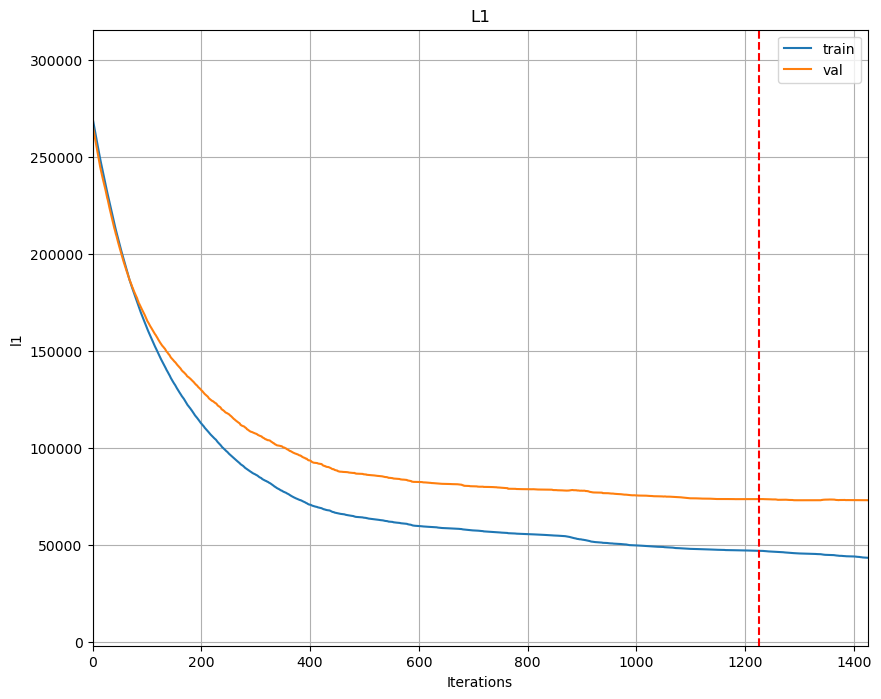

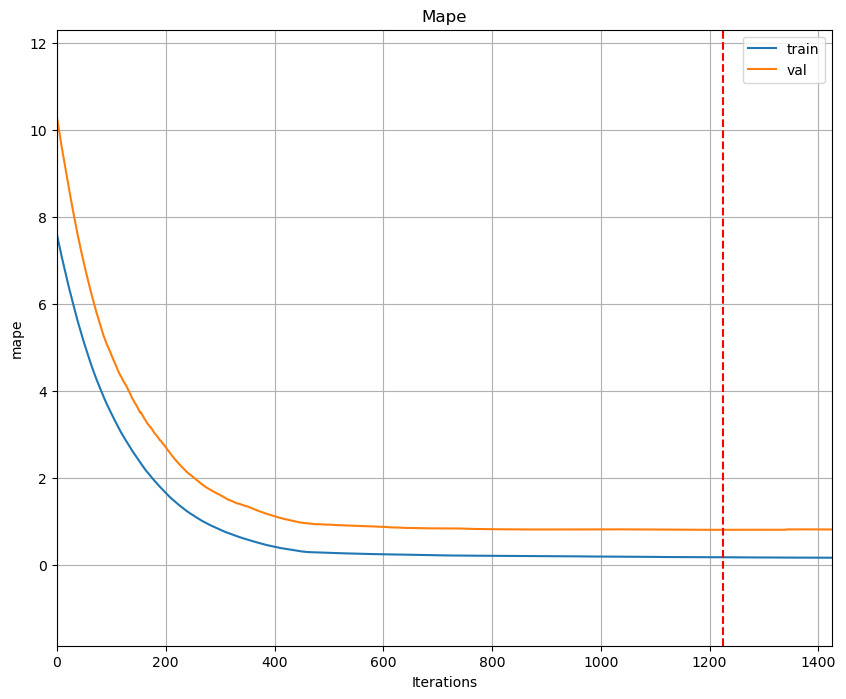

MAE Gradient boosting: 73649.03
MAPE Gradient boosting: 0.80


In [250]:
mlflow.set_experiment(experiment_name='Gradient boosting')
mlflow.set_tracking_uri("file://D:/IT/Data_science/lessons/16. lesson 16.01/mlruns")

with mlflow.start_run(run_name='l1 loss'):

    train_data = lgbm.Dataset(X_train, label=y_train)
    val_data = lgbm.Dataset(X_val, label=y_val)

    hyperparams = {
        'objective': 'l1',
        'metrics': ['mae', 'mape'],
        'learning_rate': 0.01,
        'num_iterations': 5_000,
        'max_depth': 8,
        'num_leaves': 38,
        'min_child_samples': 8,
        'bagging_fraction': 1,
        'bagging_freq': 0,
        'feature_fraction': 1,
        'lambda_l1': 0.7,
        'random_state':26
        }

    training_history = {}

    callbacks = [
        log_evaluation(30),
        early_stopping(200),
        record_evaluation(training_history)
    ]

    boosting_model_l1 = lgbm.train(params=hyperparams,
                                train_set=train_data,
                                valid_sets=[train_data, val_data],
                                valid_names=['train', 'val'],
                                callbacks = callbacks)

    _, axis = plt.subplots(figsize=(10, 8))
    lgbm.plot_metric(training_history, metric='l1', title='L1', ax=axis)
    axis.axvline(x=boosting_model_l1.best_iteration, color='red', linestyle='--')

    _, axis = plt.subplots(figsize=(10, 8))
    lgbm.plot_metric(training_history, metric='mape', title='Mape', ax=axis)
    axis.axvline(x=boosting_model_l1.best_iteration, color='red', linestyle='--')
    plt.show()

    y_pred_boosting_model = boosting_model_l1.predict(X_val)

    mae_boosting_model = mean_absolute_error(y_val, y_pred_boosting_model)
    mape_boosting_model = mean_absolute_percentage_error(y_val, y_pred_boosting_model)
    print(f"MAE Gradient boosting: {mae_boosting_model:.2f}")
    print(f"MAPE Gradient boosting: {mape_boosting_model:.2f}")

    mlflow.log_metrics({'mae': mae_boosting_model, 'mape': mape_boosting_model})
    
    #Log L1 loss and MAPE for train and val sets
    best_iteration = boosting_model_l1.best_iteration-1
    for key, values in training_history.items():
        for metric_key, metric_values in values.items():
            mlflow.log_metric(f'{key}_{metric_key}', metric_values[best_iteration])

    mlflow.log_params(hyperparams)
    mlflow.end_run()

2. with Gamma loss

d:\IT\Anaconda\envs\it_academy\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 15
[LightGBM] [Info] Start training from score 12.691716
Training until validation scores don't improve for 200 rounds
[30]	train's l1: 209231	train's mape: 1.55842	val's l1: 196834	val's mape: 1.93049
[60]	train's l1: 176094	train's mape: 0.889693	val's l1: 168673	val's mape: 1.15809
[90]	train's l1: 153488	train's mape: 0.611895	val's l1: 151839	val's mape: 0.880696
[120]	train's l1: 136710	train's mape: 0.46267	val's l1: 137376	val's mape: 0.72328
[150]	train's l1: 122759	train's mape: 0.370379	val's l1: 125096	val's mape: 0.62761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

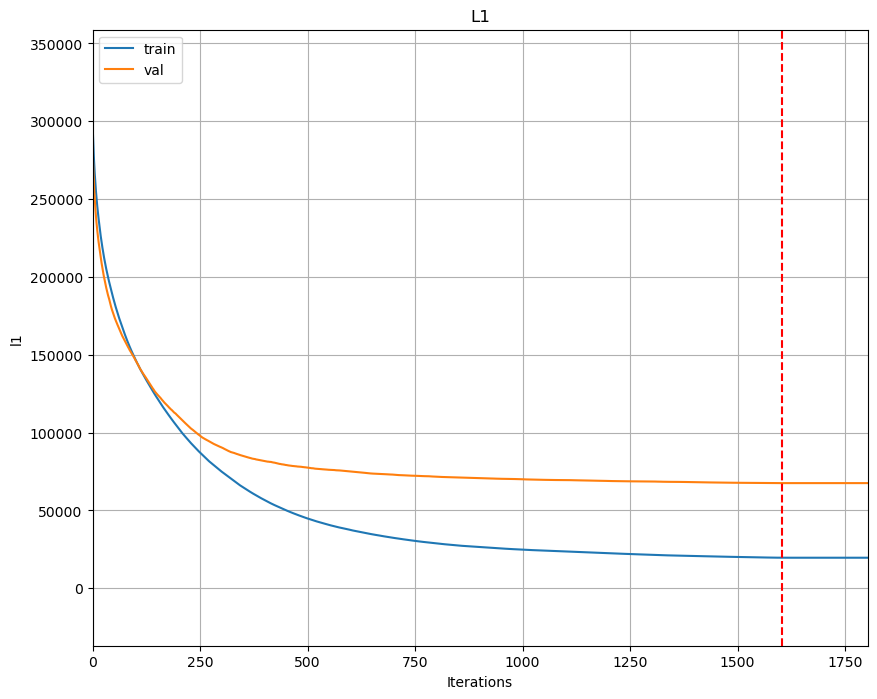

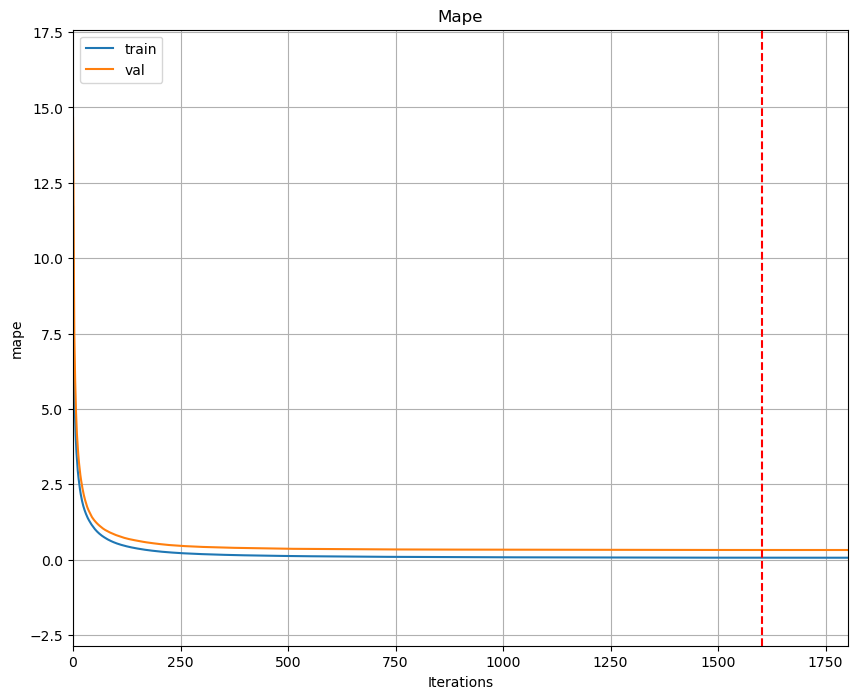

MAE Gradient boosting: 67574.55
MAPE Gradient boosting: 0.32


In [251]:
mlflow.set_experiment(experiment_name='Gradient boosting')
mlflow.set_tracking_uri("file://D:/IT/Data_science/lessons/16. lesson 16.01/mlruns")

with mlflow.start_run(run_name='Gamma loss'):

    train_data = lgbm.Dataset(X_train, label=y_train)
    val_data = lgbm.Dataset(X_val, label=y_val)

    hyperparams = {
        'objective': 'Gamma',
        'metrics': ['mae', 'mape'],
        'learning_rate': 0.01,
        'num_iterations': 5_000,
        'max_depth': 8,
        'num_leaves': 38,
        'min_child_samples': 8,
        'bagging_fraction': 1,
        'bagging_freq': 0,
        'feature_fraction': 1,
        'lambda_l1': 0.7,
        'random_state':26
        }

    training_history = {}

    callbacks = [
        log_evaluation(30),
        early_stopping(200),
        record_evaluation(training_history)
    ]

    boosting_model_gamma = lgbm.train(params=hyperparams,
                                train_set=train_data,
                                valid_sets=[train_data, val_data],
                                valid_names=['train', 'val'],
                                callbacks = callbacks)

    _, axis = plt.subplots(figsize=(10, 8))
    lgbm.plot_metric(training_history, metric='l1', title='L1', ax=axis)
    axis.axvline(x=boosting_model_gamma.best_iteration, color='red', linestyle='--')

    _, axis = plt.subplots(figsize=(10, 8))
    lgbm.plot_metric(training_history, metric='mape', title='Mape', ax=axis)
    axis.axvline(x=boosting_model_gamma.best_iteration, color='red', linestyle='--')
    plt.show()

    y_pred_boosting_model = boosting_model_gamma.predict(X_val)

    mae_boosting_model = mean_absolute_error(y_val, y_pred_boosting_model)
    mape_boosting_model = mean_absolute_percentage_error(y_val, y_pred_boosting_model)
    print(f"MAE Gradient boosting: {mae_boosting_model:.2f}")
    print(f"MAPE Gradient boosting: {mape_boosting_model:.2f}")

    mlflow.log_metrics({'mae': mae_boosting_model, 'mape': mape_boosting_model})
    
    #Log L1 loss and MAPE for train and val sets
    best_iteration = boosting_model_gamma.best_iteration-1
    for key, values in training_history.items():
        for metric_key, metric_values in values.items():
            mlflow.log_metric(f'{key}_{metric_key}', metric_values[best_iteration])

    mlflow.log_params(hyperparams)
    mlflow.end_run()

# 5.2 XGBoost

In [252]:
# additionally tried XGBoost after lesson

model with fit / predict

In [253]:
hyperparams = {
        'objective': 'reg:tweedie',
        'eval_metric': ['mae', 'mape'],
        'n_estimators': 1500,
        'booster': 'gbtree',
        'learning_rate': 0.1,
        'min_child_weight': 6,
        'max_depth': 8,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'max_leaves': 38,
        'reg_alpha': 0.8,
        'tree_method': 'hist',
        'max_bin': 50,
        'random_state':26
        }

In [254]:
xgboost_model = xgb.XGBRegressor(**hyperparams)
xgboost_model.fit(X_train, y_train)

y_pred_xgboost_model = xgboost_model.predict(X_val)

mae_xgboost_model = mean_absolute_error(y_val, y_pred_xgboost_model)
mape_xgboost_model = mean_absolute_percentage_error(y_val, y_pred_xgboost_model)
print(f"MAE XGBoost model: {mae_xgboost_model:.2f}")
print(f"MAPE XGBoost_model: {mape_xgboost_model:.2f}")

MAE XGBoost model: 75574.53
MAPE XGBoost_model: 0.33


model with train / predict

In [255]:
train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=y_val)

hyperparams = {
        'objective': 'reg:tweedie',
        'eval_metric': ['mae', 'mape'],
        'booster': 'gbtree',
        'eta': 0.1,
        'min_child_weight': 6,
        'max_depth': 8,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'max_leaves': 38,
        'reg_alpha': 0.8,
        'tree_method': 'hist',
        'max_bin': 50,
        'random_state':26
        }


xgboost_model = xgb.train(params=hyperparams,
                          dtrain=train_data,
                          evals=[(train_data, 'train'), (val_data, 'val')],
                          num_boost_round = 1500,
                          early_stopping_rounds = 200)

X_val_dmatrix = xgb.DMatrix(X_val)
y_pred_xgboost_model = xgboost_model.predict(X_val_dmatrix)

mae_xgboost_model = mean_absolute_error(y_val, y_pred_xgboost_model)
mape_xgboost_model = mean_absolute_percentage_error(y_val, y_pred_xgboost_model)
print(f"MAE XGBoost model: {mae_xgboost_model:.2f}")
print(f"MAPE XGBoost_model: {mape_xgboost_model:.2f}")

[0]	train-mae:325035.03684	train-mape:0.99947	val-mae:327962.32530	val-mape:0.99930
[1]	train-mae:325033.04012	train-mape:0.99936	val-mae:327960.32791	val-mape:0.99915
[2]	train-mae:325030.59493	train-mape:0.99922	val-mae:327957.88265	val-mape:0.99896
[3]	train-mae:325027.61435	train-mape:0.99904	val-mae:327954.90241	val-mape:0.99873
[4]	train-mae:325023.97656	train-mape:0.99883	val-mae:327951.26346	val-mape:0.99844
[5]	train-mae:325019.53375	train-mape:0.99857	val-mae:327946.82226	val-mape:0.99810
[6]	train-mae:325014.09896	train-mape:0.99826	val-mae:327941.38609	val-mape:0.99768
[7]	train-mae:325007.46989	train-mape:0.99787	val-mae:327934.75753	val-mape:0.99716
[8]	train-mae:324999.36743	train-mape:0.99740	val-mae:327926.65406	val-mape:0.99654
[9]	train-mae:324989.47923	train-mape:0.99682	val-mae:327916.76565	val-mape:0.99577
[10]	train-mae:324977.42428	train-mape:0.99626	val-mae:327904.69322	val-mape:0.99484
[11]	train-mae:324962.72299	train-mape:0.99560	val-mae:327889.97991	val-map

[27]	train-mae:323162.66290	train-mape:0.95147	val-mae:326112.97974	val-mape:0.96071
[28]	train-mae:322768.41409	train-mape:0.94426	val-mae:325726.02670	val-mape:0.95605
[29]	train-mae:322295.05042	train-mape:0.93596	val-mae:325257.48125	val-mape:0.94941
[30]	train-mae:321724.05015	train-mape:0.92661	val-mae:324691.09401	val-mape:0.94269
[31]	train-mae:321043.63958	train-mape:0.91614	val-mae:324020.95410	val-mape:0.93566
[32]	train-mae:320230.13111	train-mape:0.90335	val-mae:323221.56597	val-mape:0.93115
[33]	train-mae:319269.60489	train-mape:0.89060	val-mae:322269.81748	val-mape:0.92262
[34]	train-mae:318118.63162	train-mape:0.87537	val-mae:321120.94313	val-mape:0.91311
[35]	train-mae:316769.60141	train-mape:0.85911	val-mae:319790.68282	val-mape:0.90444
[36]	train-mae:315184.92061	train-mape:0.84166	val-mae:318220.32996	val-mape:0.89144
[37]	train-mae:313341.94602	train-mape:0.82252	val-mae:316404.31938	val-mape:0.88035
[38]	train-mae:311214.71265	train-mape:0.80232	val-mae:314280.843

# Results on test set

# 5.1. LighGBM

1. with L1 loss

In [256]:
y_pred_test_boosting_model_l1 = boosting_model_l1.predict(X_test)

mae_test_boosting_model_l1 = mean_absolute_error(y_test, y_pred_test_boosting_model_l1)
mape_test_boosting_model_l1 = mean_absolute_percentage_error(y_test, y_pred_test_boosting_model_l1)
print(f"MAE Gradient boosting: {mae_test_boosting_model_l1:.2f}")
print(f"MAPE Gradient boosting: {mape_test_boosting_model_l1:.2f}")

MAE Gradient boosting: 73644.41
MAPE Gradient boosting: 1.71


2. with Gamma loss

In [257]:
y_pred_test_boosting_model_gamma = boosting_model_gamma.predict(X_test)

mae_test_boosting_model_gamma = mean_absolute_error(y_test, y_pred_test_boosting_model_gamma)
mape_test_boosting_model_gamma = mean_absolute_percentage_error(y_test, y_pred_test_boosting_model_gamma)
print(f"MAE Gradient boosting: {mae_test_boosting_model_gamma:.2f}")
print(f"MAPE Gradient boosting: {mape_test_boosting_model_gamma:.2f}")

MAE Gradient boosting: 64829.25
MAPE Gradient boosting: 0.42


# 5.2. XGBoost

In [258]:
X_test_dmatrix = xgb.DMatrix(X_test)
y_pred_test_xgboost_model = xgboost_model.predict(X_test_dmatrix)

mae_test_xgboost_model = mean_absolute_error(y_test, y_pred_test_xgboost_model)
mape_test_xgboost_model = mean_absolute_percentage_error(y_test, y_pred_test_xgboost_model)
print(f"MAE XGBoost model: {mae_test_xgboost_model:.2f}")
print(f"MAPE XGBoost model: {mape_test_xgboost_model:.2f}")

MAE XGBoost model: 66837.71
MAPE XGBoost model: 0.38


# Optuna

** This is commented out, so that the optuna doesn't work every time I run the notebook

1. Mae optimization

In [259]:
# def objective(trial):
#     params = {
#         'objective': 'l1',
#         'boosting_type': 'gbdt',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 6000),
#         'max_depth': trial.suggest_int('max_depth', -1, 20),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 50),
#         'min_child_samples': trial.suggest_int('min_child_samples', 2, 20),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.05, 1),
#         #'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
#         #'min_gain_to_split': trial.suggest_int('min_gain_to_split', 0, 10),
#     }

#     model = lgbm.LGBMRegressor(**params)
#     model.fit(X_train, y_train,)

#     y_pred = model.predict(X_val)
#     mae_model = mean_absolute_error(y_val, y_pred)
#     #mape_model = mean_absolute_percentage_error(y_val, y_pred)

#     # weighted_metric = mae_model * 0.7 + mape_model * 0.3

#     return mae_model

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_value = study.best_value
# print("Best parameters:", best_params)
# print("Best value:", best_value)

In [260]:
# print(best_params)
# print(best_value)

2. Mape optimization

In [261]:
# def objective(trial):
#     params = {
#         'objective': 'l1',
#         'boosting_type': 'gbdt',
#         'n_estimators': trial.suggest_int('n_estimators', 4000, 6000),
#         'max_depth': trial.suggest_int('max_depth', -1, 10),
#         'num_leaves': trial.suggest_int('num_leaves', 30, 40),
#         'min_child_samples': trial.suggest_int('min_child_samples', 2, 10),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
#         #'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
#         #'min_gain_to_split': trial.suggest_int('min_gain_to_split', 0, 10),
#     }

#     model = lgbm.LGBMRegressor(**params)
#     model.fit(X_train, y_train,)

#     y_pred = model.predict(X_val)
#     mape_model = mean_absolute_percentage_error(y_val, y_pred)

#     return mape_model

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_value = study.best_value
# print("Best parameters:", best_params)
# print("Best value:", best_value)

1. Optuna model with mae optimization

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 15
[LightGBM] [Info] Start training from score 138395.812500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds


d:\IT\Anaconda\envs\it_academy\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

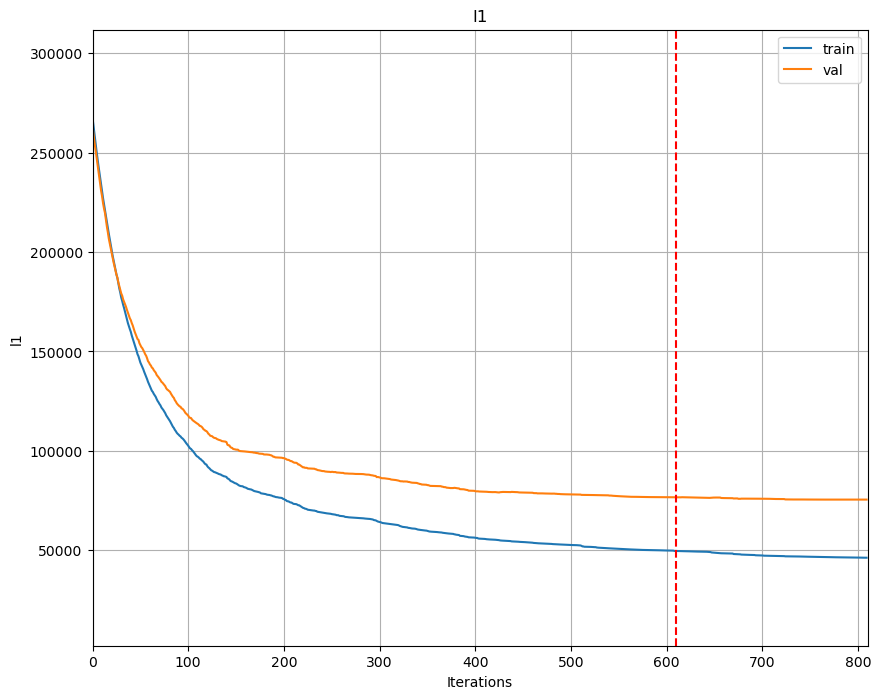

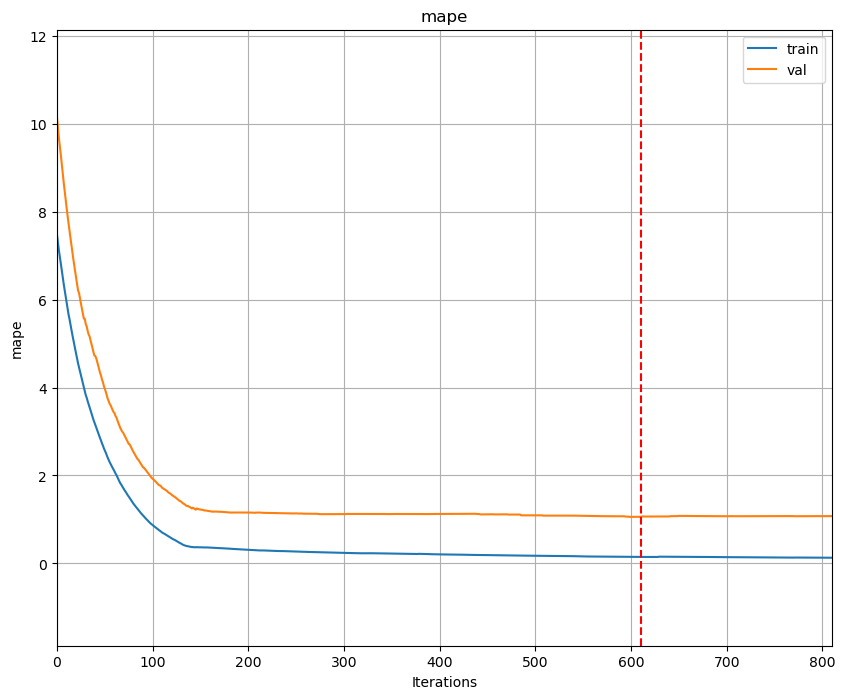

MAE Optuna model: 76643.14
MAPE Optuna model: 1.06


In [262]:
train_data = lgbm.Dataset(X_train, label=y_train)
val_data = lgbm.Dataset(X_val, label=y_val)

hyperparams = {
    'objective': 'l1',
    'metrics': ['mae', 'mape'],
    'learning_rate': 0.028,
    'num_iterations': 5_353,
    'max_depth': 6,
    'num_leaves': 39,
    'min_child_samples': 8,
    'bagging_fraction': 0.475,
    'feature_fraction': 0.723,
    'lambda_l1': 0.769,
    'random_state':26
    }

training_history = {}

callbacks = [
    log_evaluation(30),
    early_stopping(200),
    record_evaluation(training_history)
]

optuna_model = lgbm.train(params=hyperparams,
                            train_set=train_data,
                            valid_sets=[train_data, val_data],
                            valid_names=['train', 'val'],
                            callbacks = callbacks)

_, axis = plt.subplots(figsize=(10, 8))
lgbm.plot_metric(training_history, metric='l1', title='l1', ax=axis)
axis.axvline(x=optuna_model.best_iteration, color='red', linestyle='--')

_, axis = plt.subplots(figsize=(10, 8))
lgbm.plot_metric(training_history, metric='mape', title='mape', ax=axis)
axis.axvline(x=optuna_model.best_iteration, color='red', linestyle='--')
plt.show()

y_pred_optuna = optuna_model.predict(X_val)

mae_optuna_model = mean_absolute_error(y_val, y_pred_optuna)
mape_optuna_model = mean_absolute_percentage_error(y_val, y_pred_optuna)
print(f"MAE Optuna model: {mae_optuna_model:.2f}")
print(f"MAPE Optuna model: {mape_optuna_model:.2f}")


2. Optuna model with mape optimization

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 15
[LightGBM] [Info] Start training from score 138395.812500
Training until validation scores don't improve for 200 rounds
[30]	train's l1: 190296	train's mape: 4.45489	val's l1: 192151	val's mape: 6.14628
[60]	train's l1: 143516	train's mape: 2.74231	val's l1: 155986	val's mape: 4.01109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


d:\IT\Anaconda\envs\it_academy\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[90]	train's l1: 115440	train's mape: 1.74142	val's l1: 135321	val's mape: 2.86752
[120]	train's l1: 96343.6	train's mape: 1.09485	val's l1: 122028	val's mape: 2.07968
[150]	train's l1: 83665.5	train's mape: 0.722798	val's l1: 112328	val's mape: 1.62831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	train's l1: 75485.9	train's mape: 0.483651	val's l1: 105653	val's mape: 1.30872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

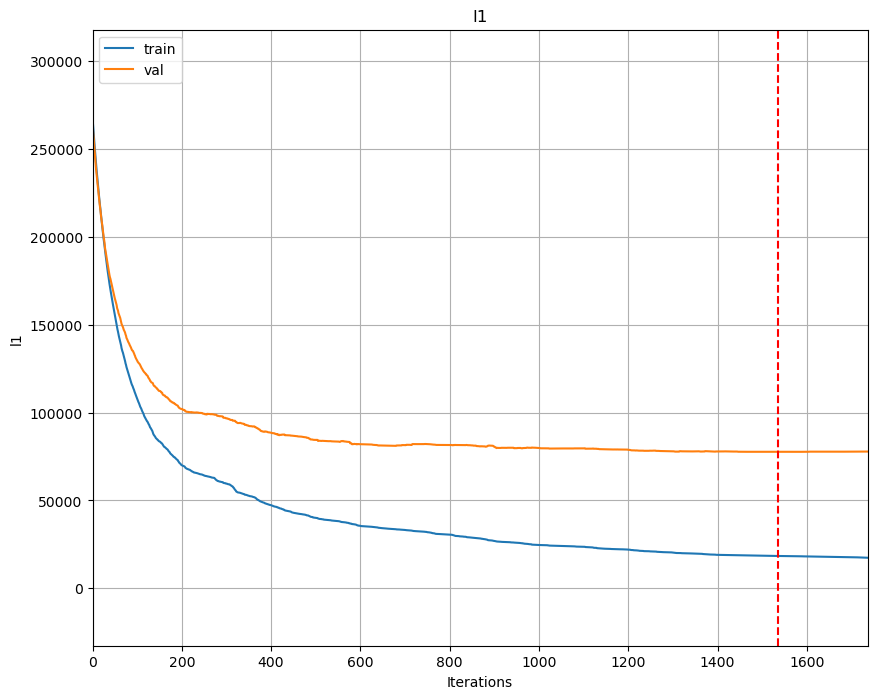

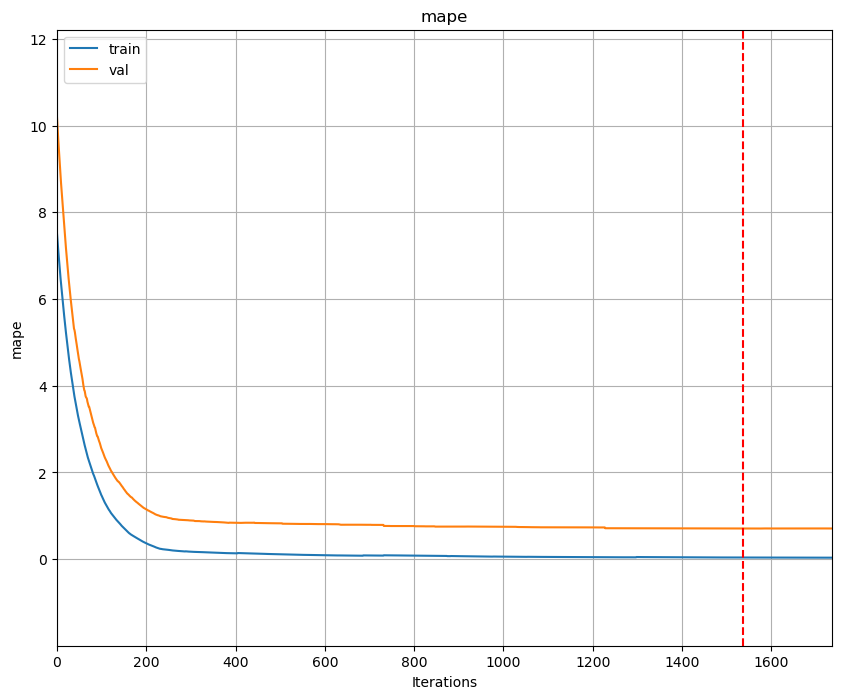

MAE Optuna model: 77659.66
MAPE Optuna model: 0.71


In [263]:
train_data = lgbm.Dataset(X_train, label=y_train)
val_data = lgbm.Dataset(X_val, label=y_val)

hyperparams = {
    'objective': 'l1',
    'metrics': ['mae', 'mape'],
    'learning_rate': 0.023,
    'num_iterations': 5_679,
    'max_depth': 7,
    'num_leaves': 32,
    'min_child_samples': 2,
    'bagging_fraction': 0.923,
    'feature_fraction': 0.892,
    'lambda_l1': 1.359,
    'random_state':26
    }

training_history = {}

callbacks = [
    log_evaluation(30),
    early_stopping(200),
    record_evaluation(training_history)
]

optuna_model = lgbm.train(params=hyperparams,
                            train_set=train_data,
                            valid_sets=[train_data, val_data],
                            valid_names=['train', 'val'],
                            callbacks = callbacks)

_, axis = plt.subplots(figsize=(10, 8))
lgbm.plot_metric(training_history, metric='l1', title='l1', ax=axis)
axis.axvline(x=optuna_model.best_iteration, color='red', linestyle='--')

_, axis = plt.subplots(figsize=(10, 8))
lgbm.plot_metric(training_history, metric='mape', title='mape', ax=axis)
axis.axvline(x=optuna_model.best_iteration, color='red', linestyle='--')
plt.show()

y_pred_optuna = optuna_model.predict(X_val)

mae_optuna_model = mean_absolute_error(y_val, y_pred_optuna)
mape_optuna_model = mean_absolute_percentage_error(y_val, y_pred_optuna)
print(f"MAE Optuna model: {mae_optuna_model:.2f}")
print(f"MAPE Optuna model: {mape_optuna_model:.2f}")